Test task scoring model

In [1]:
!pip install -q auto-sklearn

Data loading

In [1]:
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


def report(cls, X_test, y_test):
    predictions = cls.predict(X_test)
    print(classification_report(predictions, y_test))
    r = permutation_importance(cls, X_test, y_test, n_repeats=10, random_state=0)
    importances = pd.Series(r.importances_mean, index=data.columns[6:])
    sort_idx = r.importances_mean.argsort()[::-1]
    print('most important features seems to be')
    print(data.columns[6:][sort_idx[:3]])
    fig, ax = plt.subplots()
    importances.plot.bar(yerr=r.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

In [2]:
data = pd.read_csv('data.csv')

data['Unpaid,  full amount'] = data['Unpaid,  full amount'].str.rstrip('₽').str.replace(u'\xa0', '').astype('float')
data['Earned interest'] = data['Earned interest'].str.rstrip('₽').str.replace(u'\xa0', '').astype('float')
data['EL'] = data['EL'].str.replace(',', '.').str.rstrip('%').astype('float') / 100.0
data['Comission, %'] = data['Comission, %'].str.replace(',', '.').str.rstrip('%').astype('float') / 100.0
data['Loan issued'] = data['Loan issued'].str.rstrip('₽').str.replace(u'\xa0', '').astype('float')

Loss = data['Unpaid,  full amount'] * data['EL']
InvestorProfit = data['Earned interest'] - Loss
Profit = InvestorProfit + data['Comission, %']
Profit_percent = Profit / data['Loan issued']

X = data[data.columns[6:]].astype('int').values
y = Profit_percent > 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Boring option

              precision    recall  f1-score   support

       False       0.24      0.60      0.34        10
        True       0.95      0.80      0.87        97

    accuracy                           0.79       107
   macro avg       0.60      0.70      0.61       107
weighted avg       0.88      0.79      0.82       107

most important features seems to be
Index(['За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'Нелогичный выбор сферы бизнеса',
       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


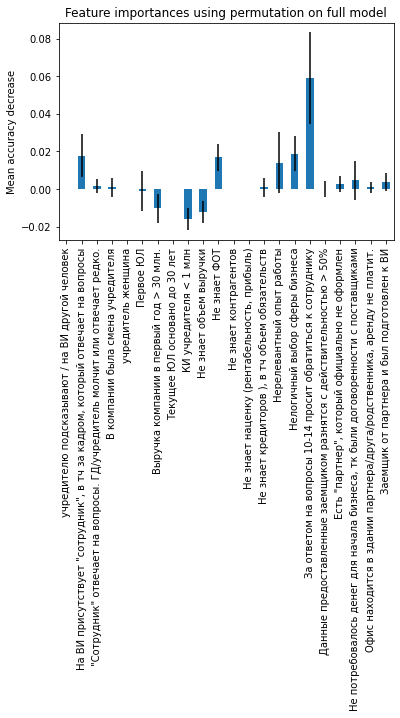

CPU times: user 2.34 s, sys: 133 ms, total: 2.47 s
Wall time: 2.43 s


In [4]:
%%time
from sklearn.ensemble import AdaBoostClassifier
cls = AdaBoostClassifier(random_state=0)
cls.fit(X_train, y_train)
report(cls, X_test, y_test)

              precision    recall  f1-score   support

       False       0.32      0.47      0.38        17
        True       0.89      0.81      0.85        90

    accuracy                           0.76       107
   macro avg       0.61      0.64      0.61       107
weighted avg       0.80      0.76      0.77       107

most important features seems to be
Index(['Первое ЮЛ', 'Нелогичный выбор сферы бизнеса',
       'Текущее ЮЛ основано до 30 лет'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


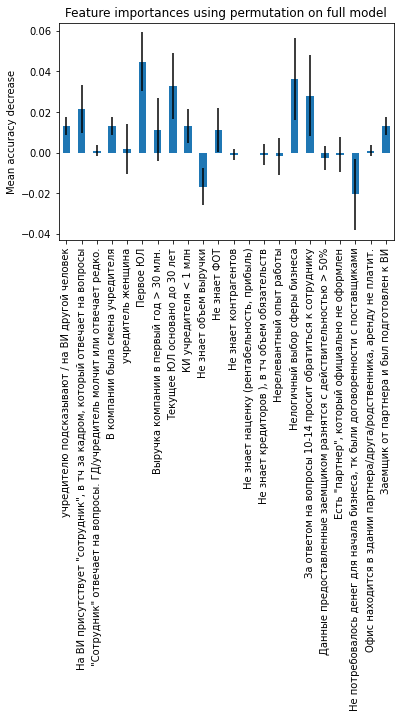

CPU times: user 3.43 s, sys: 102 ms, total: 3.54 s
Wall time: 3.67 s


In [5]:
%%time
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(random_state=0)
cls.fit(X_train, y_train)
report(cls, X_test, y_test)

              precision    recall  f1-score   support

       False       0.16      0.57      0.25         7
        True       0.96      0.79      0.87       100

    accuracy                           0.78       107
   macro avg       0.56      0.68      0.56       107
weighted avg       0.91      0.78      0.83       107

most important features seems to be
Index(['За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы',
       'Не знает ФОТ'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


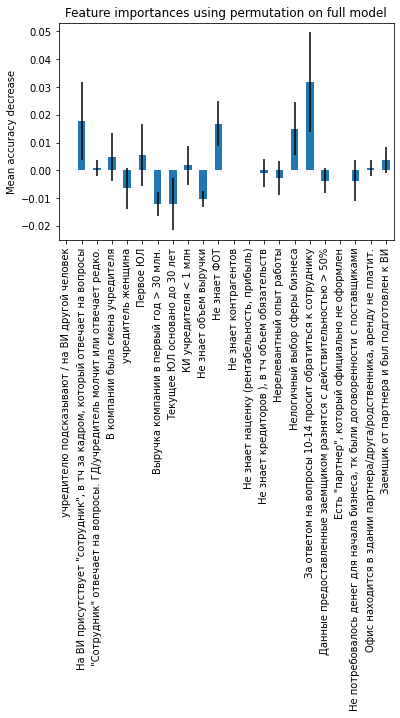

CPU times: user 37min 30s, sys: 2min 38s, total: 40min 8s
Wall time: 1h 9s


In [6]:
%%time
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
report(cls, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:154: UserWarning: SuccessiveHalving is executed with 1 workers only. Consider to use pynisher to use all available workers.
  f"{self.__class__.__name__} is executed with {num_workers} workers only. "


              precision    recall  f1-score   support

       False       0.08      0.67      0.14         3
        True       0.99      0.78      0.87       104

    accuracy                           0.78       107
   macro avg       0.53      0.72      0.51       107
weighted avg       0.96      0.78      0.85       107

most important features seems to be
Index(['За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'Заемщик от партнера и был подготовлен к ВИ',
       'Нелогичный выбор сферы бизнеса'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


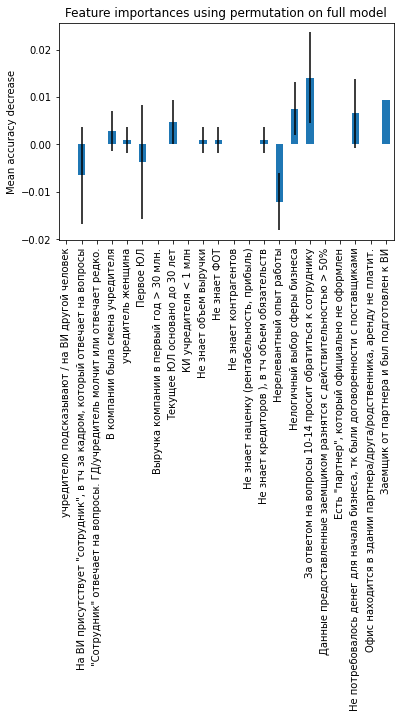

CPU times: user 16min 9s, sys: 46.2 s, total: 16min 55s
Wall time: 1h 5min 9s


In [7]:
%%time
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
cls = AutoSklearn2Classifier()
cls.fit(X_train, y_train)
report(cls, X_test, y_test)

More interesting option, like in this paper https://arxiv.org/pdf/2106.02584.pdf

In [3]:
!pip install -q x-transformers wandb
!git clone -q https://github.com/davda54/sam
!cp sam/sam.py sam.py

     |████████████████████████████████| 1.9 MB 15.5 MB/s 
     |████████████████████████████████| 182 kB 64.9 MB/s 
     |████████████████████████████████| 162 kB 40.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 162 kB 59.1 MB/s 
     |████████████████████████████████| 158 kB 40.8 MB/s 
     |████████████████████████████████| 157 kB 47.8 MB/s 
     |████████████████████████████████| 157 kB 46.7 MB/s 
     |████████████████████████████████| 157 kB 62.9 MB/s 
     |████████████████████████████████| 157 kB 56.8 MB/s 
     |████████████████████████████████| 157 kB 44.8 MB/s 
     |████████████████████████████████| 157 kB 56.4 MB/s 
     |████████████████████████████████| 157 kB 53.9 MB/s 
     |████████████████████████████████| 156 kB 62.6 MB/s 


In [4]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import torch
torch.manual_seed(3407)
from torch import nn
from x_transformers import Encoder
from tqdm.notebook import tqdm
import numpy as np

def sum_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class Model(nn.Module):
    def __init__(self, emb_num, emb_dim=16, depth=2, dropout=0.5):
        super().__init__()
        dim = emb_num * emb_dim
        self.emb = nn.ModuleList([nn.Embedding(2, emb_dim) for _ in range(emb_num)])
        self.main = Encoder(dim=dim, depth=depth, attn_dropout=dropout, ff_dropout=dropout)
        # self.main = nn.Sequential(*[nn.Sequential(nn.Linear(dim, dim), nn.Mish(inplace=True), nn.LayerNorm(dim), nn.Dropout2d(p=dropout, inplace=True)) for _ in range(depth)])
        self.out = nn.Linear(dim, 1)

    def forward(self, x):
        x = torch.cat([module(x[:,i]) for i, module in zip(range(x.shape[1]), self.emb)], dim=1)
        x = self.main(x.unsqueeze(0)).squeeze(0)
        # x = self.main(x)
        return self.out(x).squeeze(-1)

In [6]:
wandb.init(project='scoring model', entity='had', name='baseline')

wandb: Currently logged in as: had. Use `wandb login --relogin` to force relogin


In [7]:
X_train = torch.tensor(np.array(X_train)) #.cuda()
X_test = torch.tensor(np.array(X_test)) #.cuda()
y_train = torch.tensor(np.array(y_train)).float() #.cuda()
y_test = torch.tensor(np.array(y_test)).float() #.cuda()

In [8]:
model = Model(X_train.shape[1]) #.cuda()
criterion_bce = nn.BCEWithLogitsLoss()
from sam import SAM
base_optimizer = torch.optim.AdamW
optimizer = SAM(model.parameters(), base_optimizer, lr=1e-4)

In [9]:
print('model params:', sum_params(model))
print(model)

model params: 3431649
Model(
  (emb): ModuleList(
    (0): Embedding(2, 16)
    (1): Embedding(2, 16)
    (2): Embedding(2, 16)
    (3): Embedding(2, 16)
    (4): Embedding(2, 16)
    (5): Embedding(2, 16)
    (6): Embedding(2, 16)
    (7): Embedding(2, 16)
    (8): Embedding(2, 16)
    (9): Embedding(2, 16)
    (10): Embedding(2, 16)
    (11): Embedding(2, 16)
    (12): Embedding(2, 16)
    (13): Embedding(2, 16)
    (14): Embedding(2, 16)
    (15): Embedding(2, 16)
    (16): Embedding(2, 16)
    (17): Embedding(2, 16)
    (18): Embedding(2, 16)
    (19): Embedding(2, 16)
    (20): Embedding(2, 16)
    (21): Embedding(2, 16)
  )
  (main): Encoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
          (1): None
          (2): None
        )
        (1): Attention(
          (to_q): Linear(in_features=352, out_features=512, bias=False)
          (to_k): Linear(in_features=352, out_features

In [10]:
min_loss = 100
min_loss_step = 0
for step in tqdm(range(1000)):
    metrics = {}
    indexes = torch.randperm(X_train.shape[0])[:torch.randint(1, X_train.shape[0], (1,))]
    y_pred = model(X_train[indexes])
    loss = criterion_bce(y_pred, y_train[indexes])
    # model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.first_step(zero_grad=True)
    criterion_bce(model(X_train[indexes]), y_train[indexes]).backward()
    optimizer.second_step(zero_grad=True)
    metrics['bce/train'] = loss.item()
    if step % 10 == 0:
        with torch.no_grad():
            num_test_samples = len(X_test)
            y_pred_all = model(torch.cat([X_test, X_train], dim=0))
            y_pred_test = y_pred_all[:num_test_samples]
            y_pred_train = y_pred_all[num_test_samples:]
            test_loss = criterion_bce(y_pred_test, y_test).item()
            metrics['bce/test'] = test_loss
            metrics['bce/all'] = criterion_bce(y_pred_all, torch.cat([y_test, y_train], dim=0)).item()
            if min_loss > test_loss:
                min_loss = test_loss
                min_loss_step = step
                torch.save(model.state_dict(), 'model.pt')
    wandb.log(metrics)
metrics = {'bce_min/test': min_loss}
wandb.log(metrics)
wandb.finish()

  0%|          | 0/1000 [00:00<?, ?it/s]

bce/all,█▆▅▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▂▂▁▂
bce/test,▂▂▂▂▁▁▂▂▁▂▁▂▁▁▂▁▂▂▃▃▃▃▄▄▄▅▅▄▅▅▅▄▅▅▆▅▇█▆▆
bce/train,█▇▇▆▆▇▆▅▆▅▄▆▅▃▃▄▃▄▆▃▂▂▃▄▂▄▂▂▂▂▁▁▂▁▂▁▁▁▂▂
bce_min/test,▁
bce/all,0.3879
bce/test,0.90559
bce/train,0.2894
bce_min/test,0.50547


In [11]:
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
_ = model.eval()

In [12]:
with torch.no_grad():
    num_test_samples = len(X_test)
    y_pred_all = model(torch.cat([X_test, X_train], dim=0))
    y_pred_test = y_pred_all[:num_test_samples]

In [13]:
print(classification_report((y_pred_test.sigmoid() > 0.5).float().cpu().numpy(), y_test.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.36      0.64      0.46        14
         1.0       0.94      0.83      0.88        93

    accuracy                           0.80       107
   macro avg       0.65      0.74      0.67       107
weighted avg       0.86      0.80      0.83       107



In [ ]:
# seems not bad actually, but might be overfitting to test set